In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)

import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization

from tensorflow.keras import layers, models
import keras
import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download manjilkarki/deepfake-and-real-images -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
  4% 71.0M/1.68G [00:00<00:07, 225MB/s]
User cancelled operation


In [13]:
train_dir = "/content/Dataset/Train/"
valid_dir = "/content/Dataset/Validation/"
test_dir = "/content/Dataset/Test/"


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_data_dir = "/content/real_and_fake_face/"
output_base_dir = "/content/splitted_dataset/"

# Paths for train, validation, and test splits
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "validation")
test_dir = os.path.join(output_base_dir, "test")

# Create directories for train, validation, and test splits
for split_dir in [train_dir, valid_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get list of class subdirectories
classes = [d for d in os.listdir(original_data_dir) if os.path.isdir(os.path.join(original_data_dir, d))]

for class_name in classes:
    # Paths for the current class
    class_dir = os.path.join(original_data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    # Create class subdirectories
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # List all images in the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split into train, validation, and test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.125, random_state=42)  # 10% of train+valid

    # Move files to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in valid_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(valid_class_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset split complete!")

Dataset split complete!


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (128, 128)  # Resize all images to 224x224
batch_size = 1024  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    '/content/splitted_dataset/train/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='binary',
        color_mode='grayscale' , # Convert images to grayscale

    shuffle=True,
    subset='training' # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    '/content/splitted_dataset/validation/' ,
    target_size=image_shape,
        color_mode='grayscale'  ,# Convert images to grayscale

    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation' ,
    seed = 42# Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    '/content/splitted_dataset/test/',
    target_size=image_shape,
        color_mode='grayscale' , # Convert images to grayscale

    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Training Images:
Found 1250 images belonging to 2 classes.
Validating Images:
Found 25 images belonging to 2 classes.
Test Images:
Found 409 images belonging to 2 classes.


In [36]:

# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['training_fake', 'training_real']
Validation Class Names: ['training_fake', 'training_real']
Test Class Names: ['training_fake', 'training_real']
Number of Training Classes: 2
Number of Validation Classes: 2
Number of Test Classes: 2


In [37]:
class_names = train_class_names


#  VGG16



In [68]:
model = Sequential()

# Input layer explicitly defined
model.add(keras.layers.InputLayer(input_shape=(128, 128, 1)))

# Convolutional and pooling layers
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [70]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 443,633 (1.69 MB)

 Trainable params: 443,633 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# 13. Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7
)


In [72]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)


In [73]:
history = model.fit(
    train_data,
    # steps_per_epoch = (100000//1000),
    validation_data = valid_data,
    # validation_steps = (20000//1000),
    epochs = 100,
    batch_size = 8,
    callbacks = [lr_scheduler, early_stopping]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5279 - loss: 0.6978 - val_accuracy: 0.5200 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.5176 - loss: 0.6922 - val_accuracy: 0.4400 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.5079 - loss: 0.6927 - val_accuracy: 0.5200 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.5419 - loss: 0.6911 - val_accuracy: 0.5200 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 435ms/step - accuracy: 0.5197 - loss: 0.6929 - val_accuracy: 0.5200 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step - accuracy: 0.5288 - loss: 0.6921 - val_accuracy: 0.5200 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.5419 - loss: 0.6907 - val

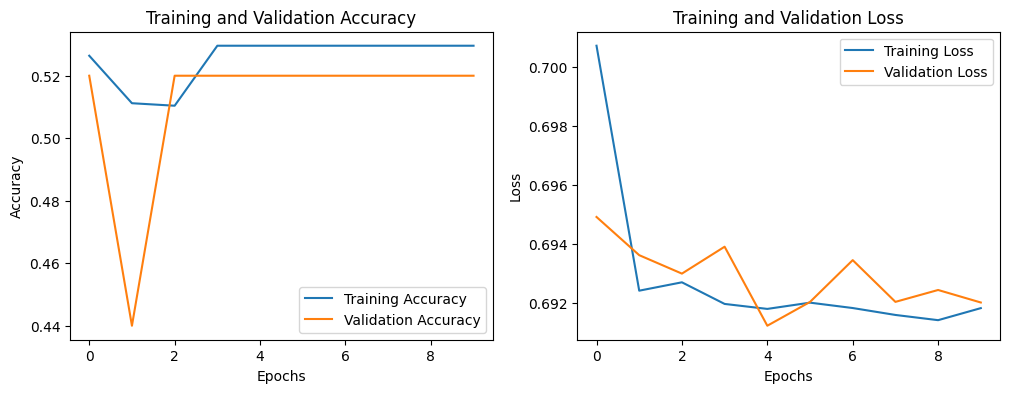

In [74]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

In [75]:
model.save("deep_fake_classification.keras")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Image 1: Predicted incorrectly. True: training_fake, Pred: training_real
Image 2: Predicted incorrectly. True: training_fake, Pred: training_real
Image 3: Predicted incorrectly. True: training_fake, Pred: training_real
Image 4: Predicted incorrectly. True: training_fake, Pred: training_real
Image 5: Predicted incorrectly. True: training_fake, Pred: training_real


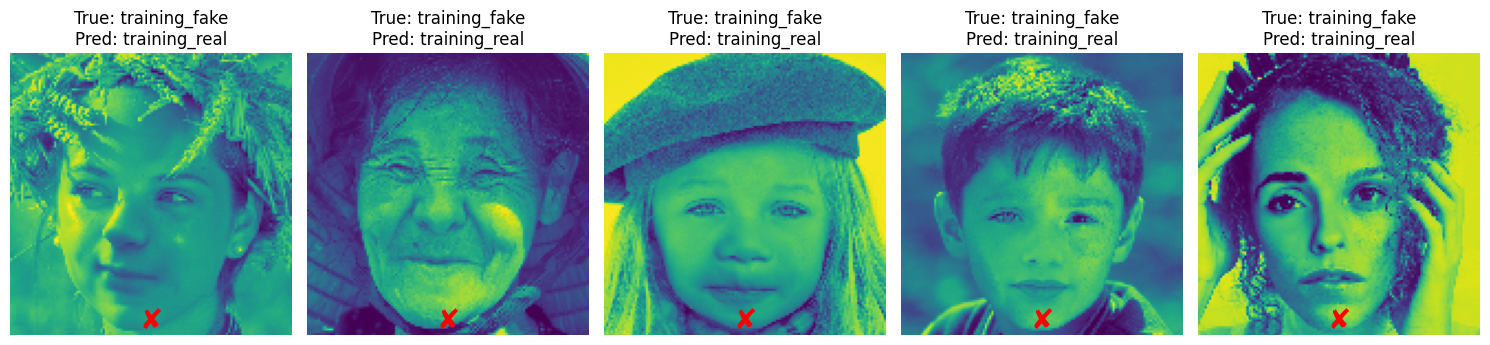

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch the first batch of images and true labels from the test data
test_images, test_labels = next(test_data)  # Get the first batch of images and labels

# Predict on these images
Y_pred = model.predict(test_images)
Y_pred_classes = (Y_pred > 0.5).astype(int).reshape(-1)  # Convert predictions to binary (0 or 1)

# Get the class names
class_names = list(test_data.class_indices.keys())

# Set up a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plot the first 5 images along with the predicted and true labels
for i in range(5):
    axes[i].imshow(test_images[i])  # Display image
    axes[i].axis('off')  # Hide axes
    true_label = int(test_labels[i])  # True label (0 or 1)
    pred_label = Y_pred_classes[i]  # Predicted label (0 or 1)

    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')

    # Check if the predicted label matches the true label
    if true_label == pred_label:
        # Display a green tick (✔) for correct prediction
        axes[i].text(0.5, 0.05, '✔', fontsize=20, color='green', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted correctly: {class_names[true_label]}')
    else:
        # Display a red cross (✘) for incorrect prediction
        axes[i].text(0.5, 0.05, '✘', fontsize=20, color='red', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted incorrectly. True: {class_names[true_label]}, Pred: {class_names[pred_label]}')

plt.tight_layout()
plt.show()


In [77]:
Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5306 - loss: 0.6915
Test loss: 0.6915383338928223
Test accuracy: 0.5305623412132263


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
               precision    recall  f1-score   support

training_fake       0.00      0.00      0.00       192
training_real       0.53      1.00      0.69       217

     accuracy                           0.53       409
    macro avg       0.27      0.50      0.35       409
 weighted avg       0.28      0.53      0.37       409



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


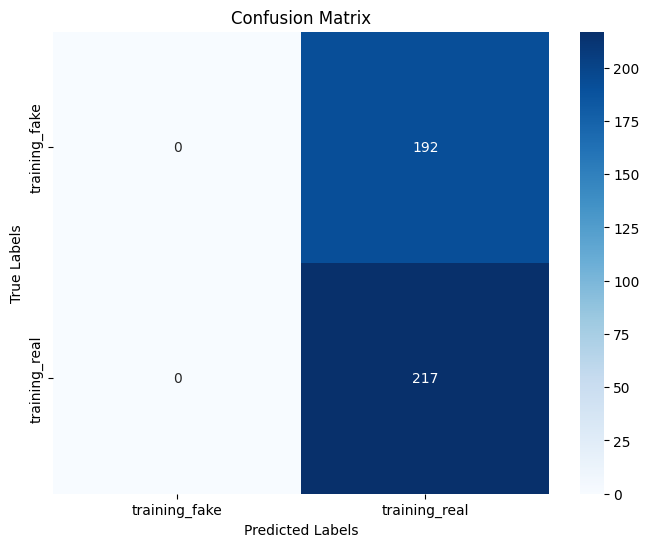

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



# Get the entire test set predictions
Y_pred = model.predict(test_data)
Y_pred_classes = (Y_pred > 0.5).astype(int).flatten()  # Flatten predictions to binary

# Extract true labels from the test data generator
true_labels = test_data.classes  # True class indices

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, Y_pred_classes, target_names=list(test_data.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(true_labels, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Classification Report:
                precision    recall  f1-score   support

training_fake       0.48      1.00      0.65        12
training_real       0.00      0.00      0.00        13

     accuracy                           0.48        25
    macro avg       0.24      0.50      0.32        25
 weighted avg       0.23      0.48      0.31        25

Precision: 0.23, Recall: 0.48, F1 Score: 0.31


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

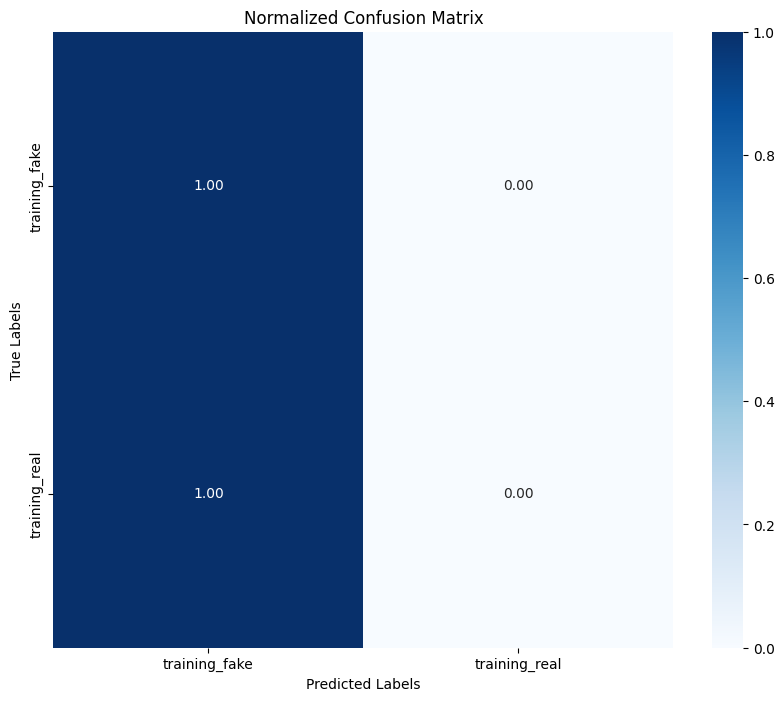

In [79]:

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()